### Data Extraction and Transformation with Python and PySpark


In [1]:
from datetime import datetime
from datetime import date
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,FloatType

spark = SparkSession.builder.appName('capstone').getOrCreate()
branches = spark.read.json("cdw_sapp_branch.json")
customers = spark.read.json("cdw_sapp_customer.json")
credits = spark.read.json("cdw_sapp_credit.json")

branchRDD = branches.rdd.map(lambda x: (x[1], x[2], x[5], x[0], x[4], x[6], '('+x[3][:3]+')'+x[3][3:6]+'-'+x[3][6:], datetime.fromisoformat(x[7])))
branches = spark.createDataFrame(data=branchRDD, schema=["BRANCH_CODE", "BRANCH_NAME", "BRANCH_STREET", "BRANCH_CITY", "BRANCH_STATE", "BRANCH_ZIP", "BRANCH_PHONE", "LAST_UPDATED"])
branches.printSchema()
customerRDD = customers.rdd.map(lambda x: (int(x[12]), x[8].title(), x[11].lower(), x[9].title(), x[1], x[13]+", "+x[0], x[2], x[6], x[3], int(x[7]), str(x[5])[:3]+"-"+str(x[5])[3:], x[4], datetime.fromisoformat(x[10])))
customers = spark.createDataFrame(data=customerRDD, schema=["SSN","FIRST_NAME","MIDDLE_NAME", "LAST_NAME", "Credit_card_no", "FULL_STREET_ADDRESS", "CUST_CITY", "CUST_STATE", "CUST_COUNTRY", "CUST_ZIP", "CUST_PHONE", "CUST_EMAIL", "LAST_UPDATED"])
customers.printSchema()
creditRDD = credits.rdd.map(lambda x: (x[1], date(x[8], x[4], x[3]).strftime('%Y%m%d'), x[2], x[0], x[6], x[7], x[5]))  
credits = spark.createDataFrame(data=creditRDD, schema=["CUST_CC_NO", "TIMEID", "CUST_SSN", "BRANCH_CODE", "TRANSACTION_TYPE", "TRANSACTION_VALUE", "TRANSACTION_ID"])
credits.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)

root
 |-- SSN: long (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- Credit_card_no: string (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_ZIP: long (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)

root
 |-- CUST_CC_NO: string (nullable = true)
 |-- TIMEID: string (nullable = true)
 |--

### Data loading into Database

In [ ]:
branches.write.format("jdbc") \
  .mode("overwrite") \
  .option("url", "jdbc:mysql://localhost:3306/credit_capstone") \
  .option("dbtable", "credit_capstone.cdw_sapp_branch") \
  .option("user", "root") \
  .option("password", "root") \
  .save()
customers.write.format("jdbc") \
  .mode("overwrite") \
  .option("url", "jdbc:mysql://localhost:3306/credit_capstone") \
  .option("dbtable", "credit_capstone.cdw_sapp_customer") \
  .option("user", "root") \
  .option("password", "root") \
  .save()
credits.write.format("jdbc") \
  .mode("overwrite") \
  .option("url", "jdbc:mysql://localhost:3306/credit_capstone") \
  .option("dbtable", "credit_capstone.cdw_sapp_credit_card") \
  .option("user", "root") \
  .option("password", "root") \
  .save()

In [ ]:
spark.stop()

### Import from API

In [ ]:
import requests
import json
response = requests.get("https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json")
print(response)

In [ ]:
loans = response.json()
loans = spark.createDataFrame(data=loans, schema=["Application_ID", "Gender", "Married", "Dependents", "Education", "Self_Employed", "Credit_History", "Property_Area", "Income", "Application_Status"])
loans.printSchema()

### Load to RDBMS

In [ ]:
loans.write.format("jdbc") \
  .mode("overwrite") \
  .option("url", "jdbc:mysql://localhost:3306/credit_capstone") \
  .option("dbtable", "credit_capstone.cdw_sapp_loan_application") \
  .option("user", "root") \
  .option("password", "root") \
  .save()

In [2]:
branches.createTempView("branches")
customers.createTempView("customers")
credits.createTempView("credit_card")
# loans.createTempView("loans")

In [4]:
spark.sql("SELECT t.TIMEID, t.TRANSACTION_ID, t.TRANSACTION_TYPE, t.TRANSACTION_VALUE \
          FROM branches b, customers c, credit_card t \
          WHERE b.BRANCH_CODE = t.BRANCH_CODE and t.CUST_CC_NO = c.Credit_card_no and t.TIMEID LIKE '201809%' and c.CUST_ZIP > 90000 and c.CUST_ZIP < 99000 \
          ORDER BY t.TIMEID DESC").show(5)

+--------+--------------+----------------+-----------------+
|  TIMEID|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|
+--------+--------------+----------------+-----------------+
|20180928|         20300|      Healthcare|            68.14|
|20180928|          7553|         Grocery|            65.53|
|20180928|          2003|      Healthcare|            72.55|
|20180928|         21083|         Grocery|             44.5|
|20180928|         27507|            Test|            69.28|
+--------+--------------+----------------+-----------------+
only showing top 5 rows



In [ ]:
spark.sql("SELECT t.TRANSACTION_TYPE, count(*) AS Orders, round(sum(t.TRANSACTION_VALUE), 2) AS Total \
          FROM credit_card t \
          GROUP BY t.TRANSACTION_TYPE").show()

In [ ]:
spark.sql("SELECT t.BRANCH_CODE as Branch, count(*) AS Orders, round(sum(t.TRANSACTION_VALUE), 2) AS Total \
          FROM credit_card t JOIN branches b on t.BRANCH_CODE = b.BRANCH_CODE \
          WHERE b.BRANCH_STATE = 'FL' \
          GROUP BY t.BRANCH_CODE").show()

In [ ]:
spark.sql("SELECT * \
          FROM customers c \
          WHERE c.SSN = 123456100").show()

In [ ]:
import mysql.connector as mariadb
from mysql.connector import Error

try:
    connection = mariadb.connect(host='localhost',
                                         database='credit_capstone',
                                         user='root',
                                         password='root')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to SQL  version ", db_Info)
        cursor = connection.cursor()
        SQLQuery ="UPDATE customers SET Credit_card_no = 4210653310061068 WHERE Credit_card_no = 4210653310061055";
        cursor.execute(SQLQuery)
except Error as e:
        print("Error while connecting to Database", e)
finally:
        if connection.is_connected():
            cursor.close()
            connection.close()
            print("Database connection is closed")

# tempView does not support update function
# spark.sql("UPDATE customers \
#           SET Credit_card_no = 4210653310061068 \
#           WHERE Credit_card_no = 4210653310061055").show()

In [16]:
spark.sql("SELECT round(sum(t.TRANSACTION_VALUE), 2) \
          FROM credit_card t \
          WHERE t.CUST_CC_NO = '4210653349028689' and startswith(t.TIMEID, '201809')").show()

+--------------------------------+
|round(sum(TRANSACTION_VALUE), 2)|
+--------------------------------+
|                          712.51|
+--------------------------------+



In [20]:
spark.sql("SELECT t.TIMEID, t.TRANSACTION_ID, t.TRANSACTION_TYPE, t.TRANSACTION_VALUE \
          FROM credit_card t \
          WHERE t.CUST_CC_NO = '4210653349028689' and t.TIMEID > '20180501' and t.TIMEID < '20180701' \
          ORDER BY EXTRACT(YEAR FROM t.TIMEID), EXTRACT(MONTH FROM t.TIMEID), EXTRACT(DAY FROM t.TIMEID) DESC").show()

+--------+--------------+----------------+-----------------+
|  TIMEID|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|
+--------+--------------+----------------+-----------------+
|20180528|             6|       Education|             6.89|
|20180519|             7|   Entertainment|            43.39|
|20180517|            15|           Bills|             29.0|
|20180511|            24|            Test|            32.81|
|20180511|            26|            Test|             86.3|
|20180604|            43|             Gas|            83.33|
|20180512|            48|       Education|             3.79|
|20180624|            60|   Entertainment|            72.17|
|20180607|            69|            Test|             93.2|
|20180612|            71|           Bills|            87.58|
|20180613|            79|             Gas|            66.48|
+--------+--------------+----------------+-----------------+



### Data Analysis and Visualization

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

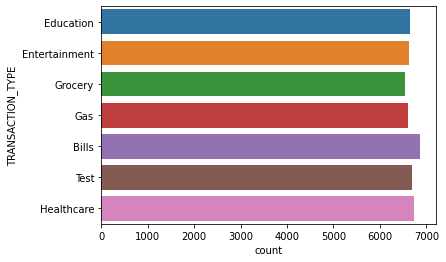

In [16]:
purchases = credits.toPandas()
ax = sns.countplot(data=purchases, y='TRANSACTION_TYPE')

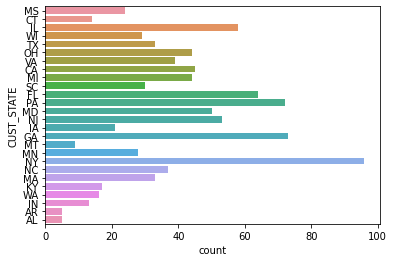

In [6]:
customers = customers.toPandas()
ax = sns.countplot(data=customers, y="CUST_STATE")

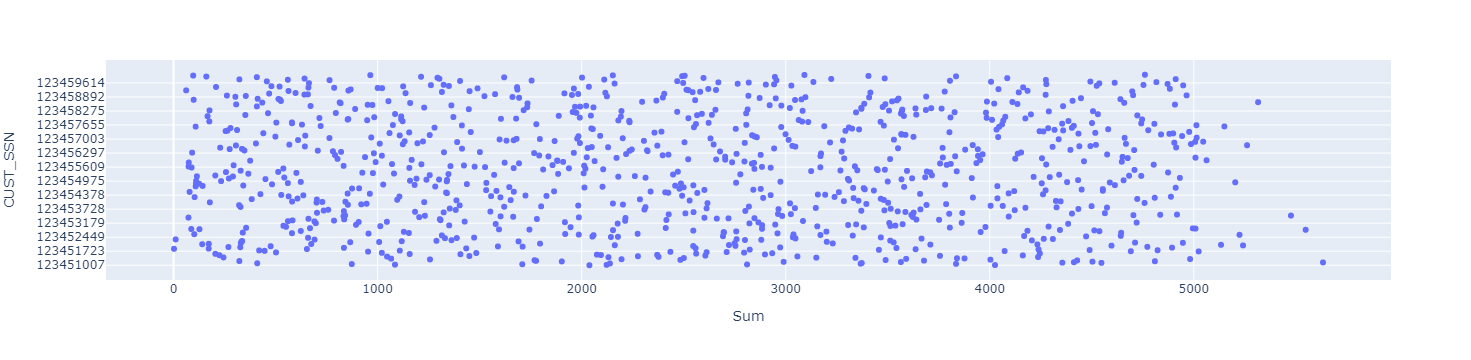

In [15]:
transaction_sums = purchases[['CUST_SSN', 'TRANSACTION_VALUE']].groupby('CUST_SSN').sum().rename(columns={"TRANSACTION_VALUE": "Sum"}).reset_index()
transaction_sums['CUST_SSN'] = transaction_sums['CUST_SSN'].astype(str)
fig = px.scatter(transaction_sums, x='Sum (Dollars)', y='CUST_SSN')
fig.show()

In [12]:
spark.sql("SELECT SUBSTRING(t.TIMEID, 5, 2), round(sum(t.TRANSACTION_VALUE), 2) \
          FROM credit_card t \
          GROUP BY SUBSTRING(t.TIMEID, 5, 2) \
          ORDER BY sum(t.TRANSACTION_VALUE) DESC").show()

+-----------------------+----------------------+
|substring(TIMEID, 5, 2)|sum(TRANSACTION_VALUE)|
+-----------------------+----------------------+
|                     10|     202583.8900000002|
|                     05|    201310.25999999998|
|                     12|    201251.07999999964|
|                     07|    201199.35000000006|
|                     02|    201086.67000000007|
|                     11|     200549.3600000001|
|                     01|    196568.87000000005|
|                     03|    196488.59000000005|
|                     08|    196453.41000000053|
|                     09|    196069.43999999994|
|                     06|    195468.74000000005|
|                     04|    194203.24999999997|
+-----------------------+----------------------+



C:\Users\vin39\AppData\Local\Temp\ipykernel_9256\812007907.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



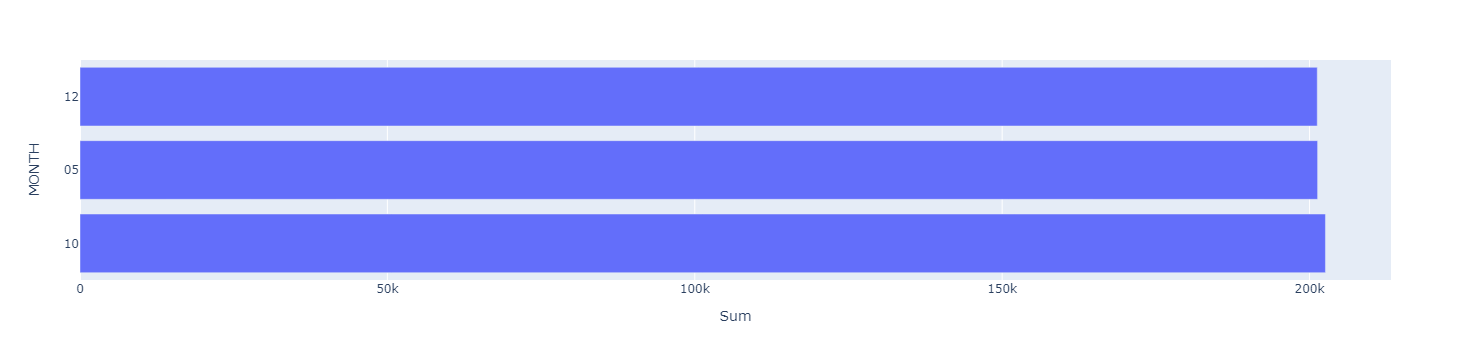

In [47]:
month_purchases = purchases[['TIMEID', 'TRANSACTION_VALUE']]
month_purchases['MONTH'] = month_purchases['TIMEID'].apply(lambda e: e[4:6])
month_sums = month_purchases.groupby('MONTH').sum().rename(columns={"TRANSACTION_VALUE": "Sum"}).reset_index().sort_values('Sum', ascending=False)
fig = px.bar(month_sums.iloc[0:3], x='Sum', y='MONTH', orientation='h')
fig.show()

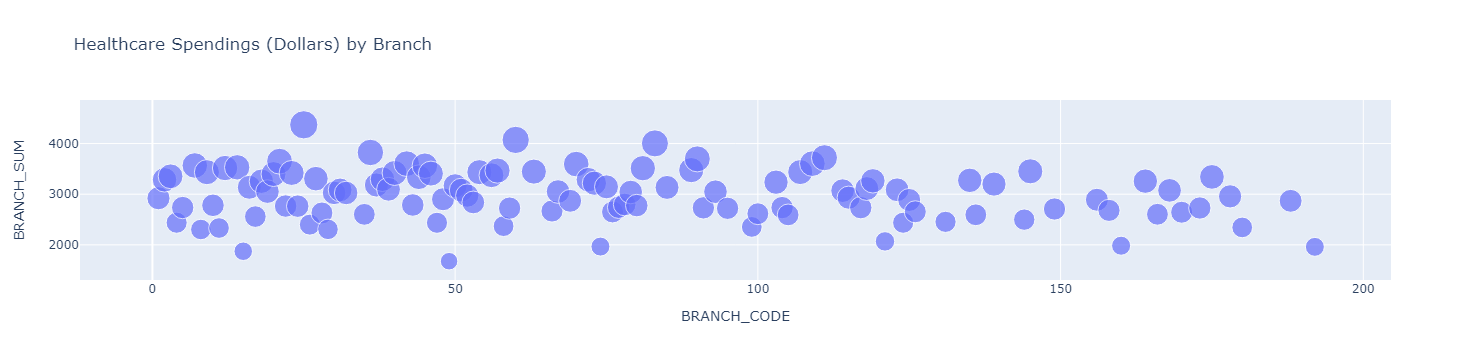

In [100]:
branch_spendings = purchases[['BRANCH_CODE', 'TRANSACTION_TYPE', 'TRANSACTION_VALUE']]
branch_spendings = branch_spendings.groupby(['TRANSACTION_TYPE', 'BRANCH_CODE']).sum().unstack()
branch_spendings = branch_spendings.loc['Healthcare'].to_frame().reset_index().drop(['level_0'], axis=1).rename(columns={"Healthcare": "BRANCH_SUM"})
branch_spendings
fig = px.scatter(branch_spendings, x='BRANCH_CODE', y='BRANCH_SUM', size='BRANCH_SUM', title="Healthcare Spendings (Dollars) by Branch")
fig.show()